`Ortalama Kare Hatası (Mean Squared Error)(MSE)`: MSE, regresyon problemlerinde kullanılan yaygın bir kayıp fonksiyonudur. Buradaki amaç, sürekli bir çıktıyı tahmin etmektir. MSE, tahmin edilen ve gerçek değerler arasındaki ortalama karesel farkı ölçer ve genellikle regresyon görevleri için sinir ağlarını eğitmek için kullanılır.

`Gradient İnişi (Gradient Descent) (GD)`: Makine öğrenimi modelinin kayıp fonksiyonunu minimize etmek için kullanılan bir optimizasyon algoritmasıdır. Kayıp fonksiyonu, modelin girdi özelliklerine dayanarak hedef değişkeni ne kadar iyi tahmin edebildiğini ölçer. GD'nin fikri, model parametrelerini kayıp fonksiyonunun en dik iniş yönünde iteratif olarak ayarlamaktır.

`Momentum`: Momentum, SGD'nin bir uzantısıdır ve parametre güncellemelerine bir "momentum" terimi ekler. Bu terim, güncellemeleri düzgün hale getirir ve gradyanın yönü veya büyüklüğü değişse bile optimizer'ı doğru yönde hareket ettirmeye devam etmesine yardımcı olur. Momentum, derin sinir ağları için özellikle faydalıdır.

`RMSprop`: RMSprop, her parametrenin öğrenme hızını adapte etmek için gradyanın karesinin hareketli ortalamasını kullanan bir optimizasyon algoritmasıdır. Bu, parametre güncellemelerinde salınımı önlemeye yardımcı olur ve bazı durumlarda konverjansı iyileştirebilir.

`Adam`: Adam, momentum ve RMSprop fikirlerini birleştiren popüler bir optimizasyon algoritmasıdır. Hem gradyanın hem de karesinin hareketli ortalamasını kullanarak her parametrenin öğrenme hızını adapte eder. Adam genellikle derin öğrenme modelleri için varsayılan bir optimizer olarak kullanılır.

`AdamW`: AdamW, Adam optimizasyonunun bir modifikasyonudur ve parametre güncellemelerine ağırlık azalma ekler. Bu, modeli düzenlemenin ve genelleme performansını iyileştirmenin yardımcı olabilir.


In [69]:
import torch
import torch.nn as nn 
from torch.nn import functional as F 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

block_size = 8
batch_size = 4
max_iters = 1000  #eğitim döngüsünde kaç tekrarın olacağı
#eval_interval = 2500
learning_rate = 3e-4
eval_iters = 250

cuda


In [70]:
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text))
print(chars)
vocab_size = len(chars)

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [71]:
#Bu kod bloğu, metni sayısal forma dönüştürme ve bu dönüşümü geri alma işlemlerini sağlar. 
string_to_int = { ch:i for i,ch in enumerate(chars) }  #Verilen bir karakter listesi (chars) üzerinde döngü yaparak, her bir karakteri ona karşılık gelen bir tamsayıya (integer) dönüştüren bir sözlük oluşturuluyor. Bu sözlük, karakterleri tamsayı indeksleri ile eşleştirir.
int_to_string = { i:ch for i,ch in enumerate(chars) }  #Tersine, tamsayı indekslerini karakterlere çeviren bir başka sözlük oluşturuluyor. Yani, önceki adımda oluşturulan string_to_int sözlüğünün tersine çevrilmiş hali.
encode = lambda s: [string_to_int[c] for c in s]  #Bir metni (string) tamsayı listesine dönüştüren bir kod parçasıdır. s isimli bir metin alır ve her karakteri string_to_int sözlüğünden ilgili tamsayı indeksine dönüştürerek bir liste oluşturur.
decode = lambda l: ''.join([int_to_string[i] for i in l])  #Ters işlemi gerçekleştiren bir kod parçasıdır. Bir tamsayı listesi alır (l), her tamsayıyı int_to_string sözlüğünden ilgili karaktere dönüştürerek orijinal metni elde eder.

data = torch.tensor(encode(text), dtype=torch.long)  #Verilen metin (text) üzerinde encode fonksiyonunu kullanarak tamsayı listesine dönüştürme işlemi gerçekleştirilir. Ardından, bu tamsayı listesini bir PyTorch long tipinde tensora çevirir.
print(data[:100])

tensor([ 1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 25, 38, 28,  1, 44, 32, 29,  1,
        47, 33, 50, 25, 42, 28,  1, 33, 38,  1, 39, 50,  0,  0,  1,  1, 26, 49,
         0,  0,  1,  1, 36, 11,  1, 30, 42, 25, 38, 35,  1, 26, 25, 45, 37,  0,
         0,  1,  1, 25, 45, 44, 32, 39, 42,  1, 39, 30,  1, 44, 32, 29,  1, 47,
        33, 50, 25, 42, 28,  1, 39, 30,  1, 39, 50,  9,  1, 44, 32, 29,  1, 36,
        25, 38, 28,  1, 39, 30,  1, 39, 50,  9])


In [72]:
n = int(0.8*len(data))  #Veri setinin %80'ini eğitim verisi olarak, geri kalan %20'sini doğrulama (validation) verisi olarak ayırmak üzere bir eşik belirleme işlemi.
train_data =  data[:n]
val_data = data[n:]

def get_batch(split):  #Verilen bir "split" değerine göre ("train" veya "val"), eğitim veya doğrulama verisi içinden rastgele bir örnek (batch) almayı sağlayan bir fonksiyon tanımlanıyor.
    data = train_data if split == 'train' else val_data  #split değerine göre işlem yaparak, fonksiyonun kullanacağı veri setini belirleme. Eğer "train" ise eğitim verisi, "val" ise doğrulama verisi seçilir.
    ix = torch.randint(len(data) - block_size, (batch_size,))  #Rastgele seçilen bir dizin (index) oluşturuluyor. Bu, eğitim veya doğrulama verisi içindeki bir başlangıç konumunu belirlemek için kullanılacaktır.
    x = torch.stack([data[i:i+block_size] for i in ix])  #Rastgele seçilen başlangıç konumlarına göre, veri setinden block_size uzunluğunda dilimler alınarak bir veri seti oluşturuluyor.
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])  #Hedef (target) veriler, giriş verilerinden bir önceki konumdan başlayarak block_size uzunluğunda alınarak oluşturuluyor.
    x, y = x.to(device), y.to(device)
    #Bu, dil modelinin bir kelimenin ardındaki kelimeyi tahmin etmeye çalıştığı bir dil modeli eğitim yaklaşımını yansıtır.
    return x, y 

x, y = get_batch('train')
print('inputs:')
#print(x.shape)
print(x)
print('targets:')
print(y)

inputs:
tensor([[73, 61, 62, 72,  1, 54,  1, 59],
        [65, 68, 75, 58,  9,  0, 73, 61],
        [ 1, 73, 54, 65, 58,  1, 28, 68],
        [60,  1, 59, 68, 74, 71,  1, 69]], device='cuda:0')
targets:
tensor([[61, 62, 72,  1, 54,  1, 59, 54],
        [68, 75, 58,  9,  0, 73, 61, 71],
        [73, 54, 65, 58,  1, 28, 68, 71],
        [ 1, 59, 68, 74, 71,  1, 69, 62]], device='cuda:0')


In [73]:
#Bu kod bloğu, eğitim verisi üzerinde bir döngü kullanarak dil modeli eğitimi için örnek giriş ve hedef çiftlerini oluşturan bir işlemi gerçekleştirir.
x = train_data[:block_size]  # Eğitim verisinin başından itibaren block_size kadar olan bölümü alınır. Bu, modelin giriş (input) verisini temsil eder.
y = train_data[1:block_size+1]  #Eğitim verisinin bir sonraki elemanından başlayarak block_size kadar olan bölümü alınır. Bu, modelin hedef (target) verisini temsil eder. Dikkat edilmesi gereken önemli bir nokta, y dizisinin x dizisiyle aynı uzunlukta olmasıdır.

for t in range(block_size):   #block_size kadar bir döngü oluşturulur. Bu döngü, her bir zaman adımında (timestep) bir örnek giriş-hedef çiftini oluşturacak.
    context = x[:t+1]  #Her bir zaman adımında, x dizisinin başından başlayarak mevcut zaman adımına kadar olan bölümü alır. Bu, dil modelinin şu ana kadar gördüğü metni temsil eder.
    target = y[t]  #Hedef (target) değeri, y dizisinin mevcut zaman adımındaki değeridir.
    print('when input is', context, 'target is', target)  # Her bir zaman adımında, mevcut giriş (context) ve hedef (target) değerlerini ekrana yazdırır. Bu, dil modelinin öğrenme sürecini takip etmek için kullanışlı olabilir.

    #Bu tür bir döngü, dil modellerinin metin verilerini öğrenirken her bir zaman adımında bir kelimenin ardındaki kelimeyi tahmin etmeye çalıştığı bir dil modeli eğitim yaklaşımını yansıtır.

when input is tensor([1]) target is tensor(1)
when input is tensor([1, 1]) target is tensor(28)
when input is tensor([ 1,  1, 28]) target is tensor(39)
when input is tensor([ 1,  1, 28, 39]) target is tensor(42)
when input is tensor([ 1,  1, 28, 39, 42]) target is tensor(39)
when input is tensor([ 1,  1, 28, 39, 42, 39]) target is tensor(44)
when input is tensor([ 1,  1, 28, 39, 42, 39, 44]) target is tensor(32)
when input is tensor([ 1,  1, 28, 39, 42, 39, 44, 32]) target is tensor(49)


In [74]:
#Bu kod bir PyTorch modelinin kaybını değerlendirmek için kullanılan bir fonksiyonu içerir.
#Fonksiyon, torch.no_grad() dekoratörü ile çevrelenmiş bir şekilde tasarlanmıştır, bu da gradyan hesaplamalarının bu bölgede devre dışı bırakılmasını sağlar. 
#Bu durumda, fonksiyonun içindeki gradyanlar takip edilmez ve bu, sadece değerlendirme amaçlı olduğunu gösterir.

@torch.no_grad()  #Bu bir dekoratördür ve içine yerleştirilen kodun gradyan hesaplamalarını devre dışı bırakır. Yani, bu bloktaki tensorların gradyanları takip edilmez.
def estimate_loss():
    out = {}
    model.eval()  #Modeli değerlendirme moduna geçirir. Bu, modeldeki dropout ve benzeri katmanlardaki davranışları değerlendirme moduna getirir. Değerlendirme modu, eğitim sırasında kullanılan normalizasyon tekniklerinin test aşamasında da kullanılmasını sağlar.
    for split in ['train', 'val']:  #Eğitim ve doğrulama setleri için bir döngü başlatır.
        losses = torch.zeros(eval_iters)  #Belirli bir veri bölümü (örneğin, 'train' veya 'val') üzerinde belirli bir sayıda (eval_iters) değerlendirme yapılır. Bu, bu iterasyonların kayıplarını saklamak için bir tensor oluşturur.
        for k in range(eval_iters):  #Belirtilen sayıda değerlendirme iterasyonu için bir iç döngü başlatır.
            X, Y = get_batch(split)  #Belirtilen veri bölümünden bir mini-batch alır.
            logits, loss = model(X,Y)  #Modeli kullanarak tahminleri yapar ve kaybı hesaplar.
            losses[k] = loss.item()  #Hesaplanan kaybı tensora ekler.
        out[split] = losses.mean()  #İç döngü bittiğinde, her bir veri bölümü için kayıpların ortalamasını çıkarır ve sonuçları out sözlüğüne ekler.
    model.train()  #Modeli eğitim moduna geri çevirir. Bu, modeldeki dropout ve benzeri katmanların eğitim sırasında kullanılan davranışlara geri dönmesini sağlar.
    return out  #Son olarak, eğitim ve doğrulama setleri için ortalama kayıpları içeren bir sözlüğü döndürür.

#Bu fonksiyon, modelin belirli bir veri seti üzerindeki kaybını değerlendirmek için kullanılabilir. 
#Bu tür bir değerlendirme, modelin performansını izlemek ve eğitim sırasında overfitting veya underfitting gibi sorunları kontrol etmek için yararlıdır.

In [75]:
class BigramLanguageModel(nn.Module):   #PyTorch'un nn.Module sınıfından türetilen BigramLanguageModel sınıfının tanımını başlatır. Bu, bir PyTorch modeli oluşturmak için gerekli olan temel sınıfı içerir.
    def __init__(self, vocab_size):     #Sınıfın başlatıcı metodudur. vocab_size parametresi, dil modelinin kullanacağı kelime dağarcığının boyutunu belirtir.
        super().__init__()              #Üst sınıfın (nn.Module) başlatıcı metodunu çağırarak başlar. Bu, BigramLanguageModel sınıfını nn.Module sınıfına türetir ve gerekli başlatıcı işlemleri gerçekleştirir.
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)   #Dil modelinin kullanacağı kelime gömme tablosunu (Embedding) oluşturur. Bu tablo, kelime indekslerini dönüştürmek için kullanılacak ve modelin öğrenilecek parametreleri içerecek.

    def forward(self, index, targets=None):  #İleri geçiş (forward pass) işlemini tanımlayan metod. Bu metod, dil modelinin bir giriş indeksi (index) ve hedefleri (targets) alarak çıktı üretmesini sağlar.
        logits = self.token_embedding_table(index)   #Giriş indeksini gömme tablosuna geçirir ve çıktı olarak alınan gömme vektörlerini (logits) elde eder. Bu adım, bir kelime indeksi için gömme vektörünü döndürür.
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape  #Elde edilen gömme vektörlerinin şeklini (shape) alır. 
            #B batch boyutunu, T zaman adımlarını ve C gömme boyutunu temsil eder.
            logits = logits.view(B*T, C)   #Gömme vektörlerini bir düzleştirme işlemiyle (view) birleştirerek iki boyutlu bir tensöre dönüştürür. Bu, çapraz entropi kaybını hesaplamak için gerekli olan formata getirme işlemidir.
            targets = targets.view(B*T)    #Hedefleri de aynı şekilde düzleştirir. Bu, hedef tensörü ile çapraz entropi hesaplaması yapılabilmesi için düzleştirilmiş logits tensörü arasında uygun boyutları sağlar.
            loss = F.cross_entropy(logits, targets)  #Düzleştirilmiş gömme vektörleri (logits) ile düzleştirilmiş hedefler (targets) arasındaki çapraz entropi kaybını hesaplar.

        return logits, loss
    
    def generate(self, index, max_new_tokens):  #bir başlangıç indeksi (index) ve maksimum yeni token sayısı (max_new_tokens) alır.
        # index is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):  #Her bir iterasyonda, modeli kullanarak bir sonraki tokeni tahmin eder ve bu tokeni indeks dizisine ekler.
            # get the predictions
            logits, loss = self.forward(index)
            # focus only on the last time step
            logits = logits[:, -1, :] #becomes (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) #(B,C)
            #sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) #(B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) #(B, T+1)
        
        return index

model = BigramLanguageModel(vocab_size)  #Bigram dil modeli oluşturulur.
m = model.to(device)  #Model, belirtilen cihaza taşınır (örneğin, GPU'ya).
#Bir başlangıç indeksi oluşturulur ve modelin generate metodunu kullanarak yeni tokenler eklenerek metin oluşturulur.

context = torch.zeros((1,1), dtype=torch.long, device=device)  #Oluşturulan metnin başlangıç indeksi.
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())  # Modelin generate metodunu kullanarak oluşturulan yeni metin.
print(generated_chars)


N17oqxH.aEjbT[lci4yQ(tYEek2drusHPpflD"xMdRYMd"SrHH6!_QlQc_f iwV,S3MObxhaE(6HAh_jNP[0T)tYAEjURm']0,[m)tYEO
)FF?G[ue[iYoX*q;( 0Ht;z:IU63h.P0R
bh_x"oXZJ79!c]_ t,q*X0Jkoj?Sc_w8ciwczRgBgb41dmHh(JF
Lh.qzj2e)Lb4nN2oTwkw*jC0HH7UQ .T_ XTLu-p1GBb7
M1R8TKArqNsqL[N7Zt0m_l]*,(BJ71dn8?1V-PH1]Yj8Cd6HtYLtMr_m_liUQllr5G:MTc0SwE0)eB]tt;S-Lu43C3yc)e-ZJ
63u4I-0Y)a6Hf?S3hXeVx"mVwGh1;!_ta Tjywvp:Lf
[YxsOe8q*Q4U_ll
LW'cqyES5"O*vyGG OeniaMlw w*X2MfFLS38"(!Do;SHHgYEN1Iiw7CQa[y1F1'7 r_jyGQZ]MtDhz) g4yok NnEuoYo!c
V0Kb4(E


logits anlatım kısmı: https://youtu.be/UU1WVnMk4E8?si=WG3-oBS_wYj4TU30&t=6703

`Çapraz entropi (Cross Entropy)`, iki olasılık dağılımı arasındaki farkı ölçen bir bilgi teorisi ölçüsüdür. İstatistik ve makine öğrenimi alanlarında, özellikle sınıflandırma problemlerinde yaygın olarak kullanılan bir kayıp fonksiyonudur.

Sınıflandırma problemlerinde çapraz entropi, model tarafından tahmin edilen olasılık dağılımı ile gerçek etiketler arasındaki uzaklığı ölçer. Eğer bu uzaklık yüksekse (yani, tahminler gerçek etiketlere benzemiyorsa), çapraz entropi değeri artar. Ama eğer uzaklık düşükse (tahminler gerçek etiketlere yakınsa), çapraz entropi değeri düşer.

Örneğin, bir sınıflandırma modeli düşünelim ve bir giriş örneğinin gerçek etiketi "kedi" ise, modelin "kedi" sınıfını tahmin etme olasılığı yüksek olmalıdır. Eğer model, gerçek etikete yakın bir olasılık tahmini yaparsa, çapraz entropi değeri düşük olacaktır. Ancak, modelin "kedi" sınıfını düşük bir olasılıkla tahmin etmesi durumunda, çapraz entropi değeri artacaktır.

`Çapraz entropi kaybı (Cross Entropy Loss)`, bu uzaklığı ölçerek modelin öğrenmesini ve iyileştirmesini sağlar. Genellikle, sınıflandırma problemlerinde kullanılan bir kayıp fonksiyonu olarak çapraz entropi, softmax aktivasyon fonksiyonu ile birlikte kullanılır. Bu sayede, modelin çıktıları bir olasılık dağılımına dönüştürülür ve çapraz entropi loss'u bu olasılık dağılımları üzerinde hesaplanır.

`AdamW`, Adam optimizasyon algoritmasının bir değişikliğidir ve ağırlıkların güncellenmesinde kullanılır. İsmi, "Weight Decay" (ağırlık azalması) terimine dayanır. Bu, L2 düzenlemesi veya ağırlıkların azaltılması anlamına gelir.

`Adam optimizasyon algoritması`, gradient tabanlı bir optimizasyon algoritmasıdır ve genellikle derin öğrenme modellerinin eğitiminde yaygın olarak kullanılır. Ancak, Adam optimizatörü, ağırlıkların azaltılması (weight decay) için özgül bir mekanizma içermez. Weight decay, ağırlıkların büyüklüklerini kontrol ederek aşırı öğrenmeyi önlemeye yardımcı olabilir.

`AdamW`, Adam optimizasyonuna weight decay ekleyen bir düzenleme (regularization) terimidir. Weight decay, ağırlıkların büyüklüklerini kontrol eder ve böylece modelin genelleme yeteneğini artırır.

AdamW'nin temel formülü şu şekildedir:
![Screenshot from 2024-01-18 16-48-59.png](<attachment:Screenshot from 2024-01-18 16-48-59.png>)

`Weight decay terimi`, ağırlıkların büyüklüklerini azaltmaya ve dolayısıyla modelin ağırlıklarını daha düzenli ve genelleştirilebilir hale getirmeye yardımcı olur. AdamW'nin amacı, Adam optimizasyonunun avantajlarını korurken aynı zamanda weight decay'in faydalarını eklemektir.
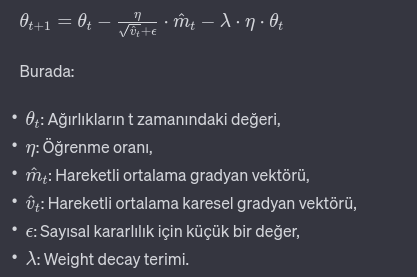

In [82]:
#Bu kod, bir dil modelini eğitmek için tipik bir eğitim döngüsünü gösterir. 
#Eğitim döngüsü boyunca model, belirli bir veri setinden örnekler alır, kaybı hesaplar, geriye doğru geçiş yapar ve optimizer aracılığıyla parametreleri günceller. 
#Bu süreç, modelin veriyi öğrenmesini ve performansını geliştirmesini sağlar.

#create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) #AdamW optimizer'ı oluşturulur. Bu optimizer, modelin parametrelerini güncellemek için AdamW optimizasyon algoritmasını kullanır. learning_rate ise öğrenme oranını temsil eder.

for iter in range(max_iters):  #Belirlenen maksimum iterasyon sayısına kadar bir döngü başlatılır.
    if iter % eval_iters == 0:  # Her eval_iters (değerlendirme iterasyonu) kadar, modelin kaybını değerlendirir.
        losses = estimate_loss()  #estimate_loss fonksiyonu ile modelin eğitim ve doğrulama setlerindeki kayıpları hesaplar.
        print(f"step {iter}: train loss {losses['train']:.3f}, val loss {losses['val']:.3f}")  #Kayıpları ekrana yazdırır.

    #sample a batch of data
    xb,yb = get_batch('train')  #Eğitim veri setinden bir mini-batch (küçük veri parçası) alınır. get_batch fonksiyonu, önceki bölümlerde tanımlanan eğitim verisini kullanarak bir mini-batch oluşturur.

    #evaluate the Loss  (Loss Hesaplama ve Geriye Doğru Geçiş)
    logits, loss = model.forward(xb, yb) #Modelin ileri geçişini yaparak çıktıları ve kaybı hesaplar.
    optimizer.zero_grad(set_to_none=True)  #Optimizerın gradient'larını sıfırlar. Bu, her iterasyonda yeni bir mini-batch ile eğitim yapılırken geçmiş gradient'ların birikmesini önler.
    loss.backward()  #Kaybın gradyanlarını hesaplar. Bu, geriye doğru geçişi başlatır.
    optimizer.step()  #Optimizer, modelin parametrelerini günceller. Bu, kaybı minimize etmek için parametrelerin güncellenmesini sağlar.
print(loss.item())  #Her iterasyonda elde edilen kayb değeri ekrana yazdırılır. Bu, modelin eğitim sürecini izlemek için kullanışlıdır.

step 0: train loss 4.179, val loss 4.165
step 250: train loss 4.111, val loss 4.091
step 500: train loss 4.048, val loss 4.050
step 750: train loss 4.013, val loss 4.011
3.721989631652832


In [83]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)


Lb4N6kF8L9sqHGNM8q;(_J';N
,xOLRL
l[OS7dXP;SnM!0'YE2Vy7Jxn6LveHt[8os&b0Gk9Y"Obu.Wbiw!stY"Ume ivyG[:5-GcWea;o0SMng(?Mn-Ln4uGuMOvPBs&mmyD?'CXZBC)?n"B07jHc]S;w3ud.axu15RYTL)D&4yEhYbD-"9U:6WiUnRQyEij8ugre Tw*sa"zCrcqk_TxsIXE
[Q5ZJ(W
vLyGQm'vd*n_!Lurb4L"BHJj80*:exzTKat;SS_iOgh_xH  XZU.qz AC[jBMOj2gA
d&QUEGGhuN153e.TareVl
V*-tMdgV*:(fOFfRom;kle7 tL)9isOAszQ:mVXLeB6!jl!Ag.WURH?X.
gV0US1)7NZ"J78sQ4Yo92d&b s;The
5lP3hth4ored1
tYENScX.8;Y;(WVdch?;yRq:"_Ffib4YTq-4TASye)!"C:(Wuqgrqw*3
aYol"0X?"CDL[e BK[0z*j2
